In [1]:
%load_ext autoreload
%autoreload 2
%cd ..

/home/nassim/dev/reinforcement-learning


In [2]:
import gym
from lib.envs.bandits import KArmedBanditsEnv
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("white")
%matplotlib inline

# Environment setup

In [4]:
# Reward distribution
mu, sigma = 0, 1
k = 10
action_values = np.random.normal(mu, sigma, k).tolist() #q*(a)
reward_dist = [[q, 1] for q in action_values]

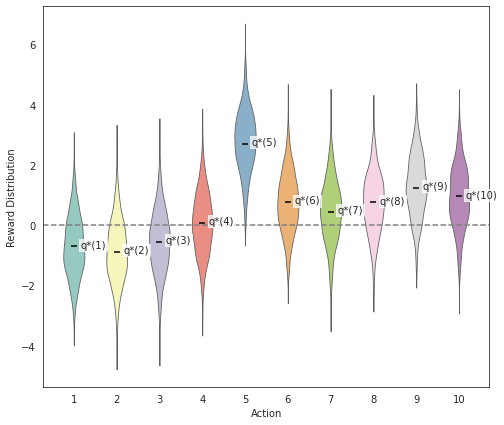

In [5]:
# Plotting the reward distributions

fig = plt.figure(figsize=(8,7))

df = pd.DataFrame()
for idx, e in enumerate(reward_dist):
    y = np.random.normal(e[0], e[1], 1000)
    df[idx+1]=pd.Series(y)
    
g = sns.violinplot(data=df, linewidth=0.8, inner=None, width=0.5, palette="Set3")
plt.scatter(x=range(len(action_values)), y=action_values, marker="_", color="black")

for idx, v in enumerate(action_values):
    plt.text(idx+0.15, v-0.05,'q*({})'.format(idx+1), 
             fontsize=10,
             bbox={'facecolor': 'white', 'alpha': 0.7, 'pad': 1})

g.axhline(0, ls='--', c="gray")
    
plt.xlabel("Action")
plt.ylabel("Reward Distribution")
plt.show()


In [6]:
env = KArmedBanditsEnv(r_dist=reward_dist)

In [7]:
np.random.seed(42) 
env.seed(42)

In [6]:
print(env.action_space)
print(env.observation_space)

Discrete(10)
Discrete(1)


In [7]:
obs = env.reset()

for ep in range(5):
    print("Episode:", ep)
    a = env.action_space.sample()
    print("Action:", a)
    obs, r, _, _ = env.step(a)
    
    print("Observation: ", obs)
    print("Reward: {:.2f}".format(r))
    print()
    
env.close()

Episode: 0
Action: 7
Observation:  0
Reward: 1.97

Episode: 1
Action: 0
Observation:  0
Reward: -0.37

Episode: 2
Action: 5
Observation:  0
Reward: -0.70

Episode: 3
Action: 7
Observation:  0
Reward: 2.99

Episode: 4
Action: 2
Observation:  0
Reward: 0.12



# ε-greedy Agent

In [8]:
# Epsilon-greedy agent with sample-average estimation

def epsilon_greedy_agent(bandits,
                         epsilon=0.1, 
                         initial=1.0, 
                         episodes=1000):
    
    Q = np.full(bandits.k, initial)
    N = np.ones(bandits.k)
    epsilon = epsilon
    
    r_list = []
    
    obs = bandits.reset()
    for ep in range(episodes):
        p = np.random.random()
        
        if p < epsilon: 
            # Exploration
            a = np.random.choice(bandits.k)
        else: 
            # Exploitation
            a = np.argmax(Q)
            
        _, r, _, _ = bandits.step(a)

        # Update tables
        Q[a] = Q[a]+(r-Q[a])/N[a]
        N[a]+=1
        r_list.append(r)
    
    return Q, N, r_list

In [9]:
episodes = 1000
Q, N, r = epsilon_greedy_agent(env, episodes=episodes)

In [10]:
best_bandit = np.argmax(Q)+1
real_best_bandit = np.argmax(action_values)+1

print(best_bandit)
print(real_best_bandit)

5
5


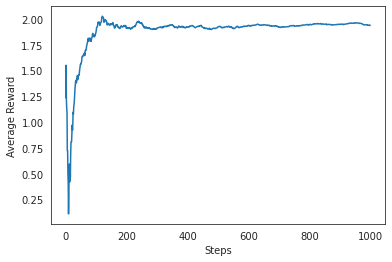

In [11]:
cum_reward = np.cumsum(r)/(np.arange(episodes)+1)
plt.plot(cum_reward)
plt.xlabel("Steps")
plt.ylabel("Average Reward")
plt.show()


## Parameter comparison

In [12]:
_, _, r1 = epsilon_greedy_agent(env, episodes=episodes, epsilon=0.1, initial=0.0)
_, _, r2 = epsilon_greedy_agent(env, episodes=episodes, epsilon=0.01, initial=0.0)
_, _, r3 = epsilon_greedy_agent(env, episodes=episodes, epsilon=0.0, initial=0.0)

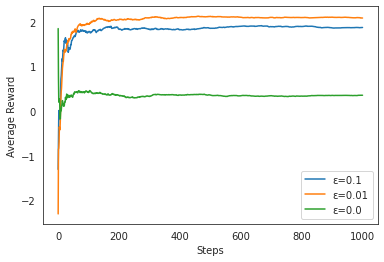

In [13]:

for e in [(r1, 0.1), (r2, 0.01), (r3, 0.0)]:
    cum_reward = np.cumsum(e[0])/(np.arange(episodes)+1)
    plt.plot(cum_reward, label="ε={}".format(e[1]))
plt.xlabel("Steps")
plt.ylabel("Average Reward")
plt.legend()
plt.show()

In [14]:
_, _, r1 = epsilon_greedy_agent(env, episodes=episodes, initial=0.0)
_, _, r2 = epsilon_greedy_agent(env, episodes=episodes, initial=1.0)
_, _, r3 = epsilon_greedy_agent(env, episodes=episodes, initial=3.0)

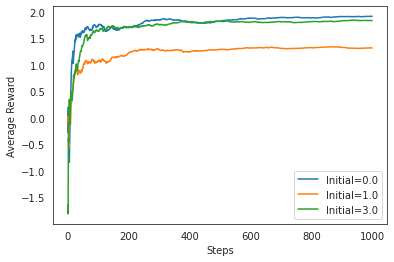

In [15]:

for e in [(r1, 0.0), (r2, 1.0), (r3, 3.0)]:
    cum_reward = np.cumsum(e[0])/(np.arange(episodes)+1)
    plt.plot(cum_reward, label="Initial={}".format(e[1]))
plt.xlabel("Steps")
plt.ylabel("Average Reward")
plt.legend(loc="lower right")
plt.show()

# Upper Confidence Bound (UCB) Agent

In [7]:
# UCB agent

def UCB_agent(bandits,
              initial=1.0,
              c=2, 
              episodes=1000):
    
    Q = np.full(bandits.k, initial)
    N = np.zeros(bandits.k)
    
    r_list = []
    
    obs = bandits.reset()
    for ep in range(episodes):
        
        ucb = [Q[a]+c*np.sqrt(np.log(ep)/N[a])
               for a in range(bandits.k)]
        a = np.argmax(ucb)   
        _, r, _, _ = bandits.step(a)

        # Update tables
        N[a]+=1
        Q[a] = Q[a]+(r-Q[a])/N[a]
        r_list.append(r)
    
    return Q, N, r_list

In [17]:
Q, N, r = UCB_agent(env, episodes=episodes)

In [18]:
best_bandit = np.argmax(Q)+1
real_best_bandit = np.argmax(action_values)+1

print(best_bandit)
print(real_best_bandit)

5
5


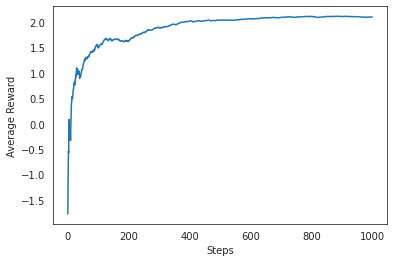

In [19]:
cum_reward = np.cumsum(r)/(np.arange(episodes)+1)
plt.plot(cum_reward)
plt.xlabel("Steps")
plt.ylabel("Average Reward")
plt.show()


## Parameter comparison

In [20]:
_, _, r1 = UCB_agent(env, episodes=episodes, c=1)
_, _, r2 = UCB_agent(env, episodes=episodes, c=2)
_, _, r3 = UCB_agent(env, episodes=episodes, c=3)

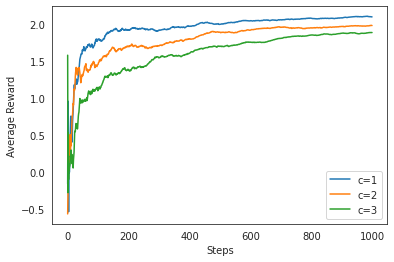

In [21]:
for e in [(r1, 1), (r2, 2), (r3, 3)]:
    cum_reward = np.cumsum(e[0])/(np.arange(episodes)+1)
    plt.plot(cum_reward, label="c={}".format(e[1]))
plt.xlabel("Steps")
plt.ylabel("Average Reward")
plt.legend(loc="lower right")
plt.show()

In [22]:
_, _, r1 = UCB_agent(env, episodes=episodes)
_, _, r2 = epsilon_greedy_agent(env, episodes=episodes)

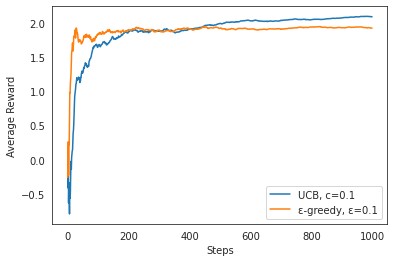

In [23]:

cum_reward = np.cumsum(r1)/(np.arange(episodes)+1)
plt.plot(cum_reward, label="UCB, c=0.1")
cum_reward = np.cumsum(r2)/(np.arange(episodes)+1)
plt.plot(cum_reward, label="ε-greedy, ε=0.1")
plt.xlabel("Steps")
plt.ylabel("Average Reward")
plt.legend(loc="lower right")
plt.show()

# Non-stationary environment

In [8]:
env_non_stat = KArmedBanditsEnv(r_dist=reward_dist, non_stat=True)

In [42]:
# Epsilon-greedy agent with exponencial-recency weighting estimation

def epsilon_greedy_weighted_agent(bandits,
                         epsilon=0.1, 
                         initial=1.0, 
                         episodes=1000,
                         alpha=0.1):
    
    Q = np.full(bandits.k, initial)
    N = np.ones(bandits.k)
    epsilon = epsilon
    
    r_list = []
    
    obs = bandits.reset()
    for ep in range(episodes):
        p = np.random.random()
        
        if p < epsilon: 
            # Exploration
            a = np.random.randint(k)
        else: 
            # Exploitation
            a = np.argmax(Q)
            
        _, r, _, _ = bandits.step(a)

        # Update tables
        Q[a] = Q[a]+alpha*(r-Q[a])
        N[a]+=1
        r_list.append(r)
    
    return Q, N, r_list

In [43]:
# UCB agent with exponencial-recency weighting

def UCB_weighted_agent(bandits,
              initial=1.0,
              c=2, 
              episodes=1000,
              alpha=0.1):
    
    Q = np.full(bandits.k, initial)
    N = np.zeros(bandits.k)
    
    rewards = np.zeros(episodes)
    
    obs = bandits.reset()
    for ep in range(episodes):
        
        ucb = [Q[a]+c*np.sqrt(np.log(ep)/N[a])
               for a in range(bandits.k)]
        a = np.argmax(ucb)   
        _, r, _, _ = bandits.step(a)

        # Update tables
        N[a]+=1
        Q[a] = Q[a]+alpha*(r-Q[a])
        rewards[ep] = r
    
    return Q, N, rewards

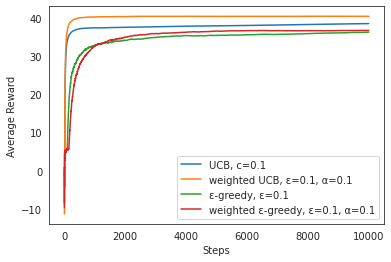

In [48]:
episodes = 10000
_, _, r1 = UCB_agent(env_non_stat, episodes=episodes)
_, _, r2 = epsilon_greedy_agent(env_non_stat, episodes=episodes)
_, _, r3 = epsilon_greedy_weighted_agent(env_non_stat, episodes=episodes)
_, _, r4 = UCB_weighted_agent(env_non_stat, episodes=episodes)

cum_reward = np.cumsum(r1)/(np.arange(episodes)+1)
plt.plot(cum_reward, label="UCB, c=0.1")

cum_reward = np.cumsum(r4)/(np.arange(episodes)+1)
plt.plot(cum_reward, label="weighted UCB, ε=0.1, α=0.1")

cum_reward = np.cumsum(r2)/(np.arange(episodes)+1)
plt.plot(cum_reward, label="ε-greedy, ε=0.1")

cum_reward = np.cumsum(r3)/(np.arange(episodes)+1)
plt.plot(cum_reward, label="weighted ε-greedy, ε=0.1, α=0.1")

plt.xlabel("Steps")
plt.ylabel("Average Reward")
plt.legend(loc="lower right")
plt.show()

# Gradient Bandits

In [28]:
# Gradient agent

def gradient_agent(bandits,
              episodes=1000,
              alpha=0.1):
    
    actions = np.arange(bandits.k)
    # Action preferences
    H = np.zeros(bandits.k)
    # Action probabilities (softmax)
    pi = []
    softmax = lambda H: np.exp(H - np.max(H)) \
        / np.sum(np.exp(H - np.max(H)), axis=0)
    
    rewards = np.zeros(episodes)
    avg_reward = 0

    obs = bandits.reset()
    for ep in range(1, episodes+1):
        pi = softmax(H)

        a = np.argmax(pi)
        _, r, _, _ = bandits.step(a)

        # Update probabilities
        rewards[ep-1] = r
        
        H[a] = H[a] + alpha * (r - avg_reward) * (1-pi[a])
        not_a = actions != a
        H[not_a] = H[not_a] - alpha*(r - avg_reward)*pi[not_a]

        avg_reward = avg_reward + (r - avg_reward) / ep
    
    return Q, N, rewards

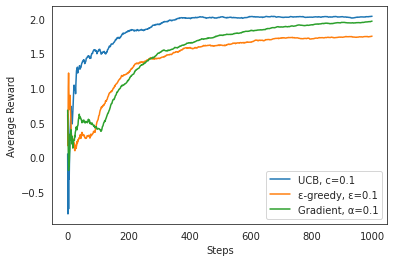

In [30]:
_, _, r1 = UCB_agent(env, episodes=episodes)
_, _, r2 = epsilon_greedy_agent(env, episodes=episodes)
_, _, r3 = gradient_agent(env, episodes=episodes)

cum_reward = np.cumsum(r1)/(np.arange(episodes)+1)
plt.plot(cum_reward, label="UCB, c=0.1")

cum_reward = np.cumsum(r2)/(np.arange(episodes)+1)
plt.plot(cum_reward, label="ε-greedy, ε=0.1")

cum_reward = np.cumsum(r3)/(np.arange(episodes)+1)
plt.plot(cum_reward, label="Gradient, α=0.1")

plt.xlabel("Steps")
plt.ylabel("Average Reward")
plt.legend(loc="lower right")
plt.show()